In [1]:
# Playgroud Series - Binary Classification of Insurance Cross Selling
  # https://www.kaggle.com/competitions/playground-series-s4e7
  # Your Goal: predict which customers respond positively to an automobile insurance offer.
  # Metric: Submissions are evaluated using area under the ROC curve.

# Lessons Learned:
    # Increase complexity slow: lost 3 pomos trying to implement to much complexity --> implement JUST 1 new thing a time (incremental learning)

# Improvements (to do)

In [1]:
#DONE v1 and v2:
# use more data (used 100k on train).  -> DT was practically not improved, even with 1.5M rows on test. Saw an post showing there are many repeated rows on dataset.
    # There are no duplicated rows on test data (11M). Removind 1 feature per time, all of them have many duplicates (downsampling). There was no gain of doing that. (https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517167)
# Plot ROC_AUC curve to compare moodel

#DONE V3:
#Probabilistic approach

#DONE V4:
# tested LogisticRegressionCV and  LogisticRegression + GridSearchCV (fine tuning). -> RF is still superior.

#DONE V5:
# CatBoost wuthout default params

#DONE V6
# Balance CatBoost -> did not imporve
# CatBoost + GridSearchCV -> did not improve
# CatBoost + GridSearchCV of [AutoML Grand Prix] 1st Place Solution (https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution) -> did not improve

#DONE V7
# Data Prep/Feature Engeering and Cat Boost of [AutoML Grand Prix] 1st Place Solution (https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution)
    # Did not run with 11Mi train rows locally (few mommory). Tried w/ 100k train and full test (needed to submit).
    # User iterations=1000 instead of 5000, and task_type= 'CPU', cause 'GPU' -> Demands NVidea graphics cards w/ CUDA
    # Undestood StratifiedKFold w/ CatBoost cross validation
    # Kaggle public score: 0.884 (best by far!)

#DONE V8:
# Optimize hiperparameters with Scikit Optimize BayesSearchCV
    # Used BayesSearchCV. Got 0.871 on public. Had 0.884 with StratifiedKFold. Looks like its critic on this kind of problem.

#DONE V9:
#Try using both BayesSearchCV and StratifiedKFold, to improve performance. Did not work.
# Plotted Roc Auc Curve + conf. matrix.

#TODO V10:
#Improve EDA - ref: https://www.kaggle.com/code/rzatemizel/stacking-xgb-lgbm-catb-ann/notebook

#######################
#TODO:
#improve EDA
#organize notebook with classes
#stacking

In [ ]:
#PS: Below code needs to be reviewed!

# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import polars as pl

from sklearn.model_selection       import train_test_split, GridSearchCV, StratifiedKFold#, cross_val_score
from sklearn.preprocessing         import MinMaxScaler #OneHotEncoder  
from sklearn.metrics               import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree                  import DecisionTreeClassifier, plot_tree
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import LogisticRegressionCV, LogisticRegression

from catboost                      import CatBoostClassifier, Pool #Numpy downgrade needed: pip install numpy==1.26.4 (from mar/24)
from sklearn.pipeline              import Pipeline
from skopt                         import BayesSearchCV, space

pd.set_option('max_colwidth', 500) #cols to be shown
pd.set_option('display.float_format', lambda x: '%.3f' % x) #pandas decimal places
np.set_printoptions(suppress=True, precision=3)#numpy decimal places

# Load Data

In [28]:
import pandas as pd
train = pd.read_csv('..\\data\\kaggle\\train.csv', index_col='id')
train.shape

(11504798, 11)

In [19]:
## load data
#train = pl.read_csv('..\\data\\kaggle\\train.csv')

# Specify the path to your CSV file and read a random sample of the dataset
train = pd.read_csv('..\\data\\kaggle\\train.csv', index_col='id').sample(n=50000)
train.reset_index(inplace=True)
#test = pd.read_csv('..\\data\\kaggle\\test.csv', index_col='id') #.sample(n=70000) needs to be full, cause I neet to submit all the rows!

In [23]:
print(train.shape)
train[:2]

(50000, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,4178147,Male,64,1,45.000,0,1-2 Year,Yes,36397.000,26.000,31,0
1,7744262,Female,30,1,47.000,1,< 1 Year,No,30888.000,124.000,250,0


In [24]:
print(test.shape)
test[:2]

(7669866, 10)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
11504798,Female,20,1,47.000,0,< 1 Year,No,2630.000,160.000,228
11504799,Male,47,1,28.000,0,1-2 Year,Yes,37483.000,124.000,123


In [ ]:
#This function reduces memory usage. Reference: https://www.kaggle.com/code/jmascacibar/optimizing-memory-usage-with-insurance-cross-sell/notebook
def shrink_and_dummify(df):
    df["Vehicle_Age"] = df["Vehicle_Age"].replace({"1-2 Year": 1, "< 1 Year": 0, "> 2 Years": 2}).astype('int8')
    df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1}).astype('int8')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].replace({'No': 0, 'Yes': 1}).astype('int8')
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')
    
    if 'Response' in df.columns:
        df['Response'] = df['Response'].astype('int8')
    
    return df

In [5]:
## prepare data
df = pl.concat([train, test])

df = df.with_columns([
    pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
    pl.col('Region_Code').cast(int),
    pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
    pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
    pl.col('Annual_Premium').cast(int),
    pl.col('Policy_Sales_Channel').cast(int)
])

df = df.with_columns([
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Annual_Premium'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Age'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Age'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Damage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Damage'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vintage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vintage')
])

train = df[:train.shape[0]].to_pandas()
test = df[train.shape[0]:].to_pandas()

In [6]:
#convert all cols to lower case, and replace spaces and dots with underscores
train.columns = train.columns.str.replace(' ','_').str.replace('.','_').str.lower()
test.columns = test.columns.str.replace(' ','_').str.replace('.','_').str.lower()

In [7]:
#Why just interactions with Previously_Insured variable?
    #https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516475#2901376
#-> We ran all combinations of interactions on a smaller subset (500K rows) and chose the Top-3/4 based on feature importance. 
    #Any interaction with Previously_Insured seemed to work the best

# It was on top of feature importance, as seen on other topic:
    #https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516860

#Feature Engeneering with high Feature Importances:
    #https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517112
    #Previously_Insured_Vehicle_Damage
    #Vehicle_Age_Damage

In [8]:
# PANDAS EQUIVALENT:

# Concatenate train and test DataFrames
# df_pd = pd.concat([train_pd, test_pd], ignore_index=True)

# # Convert specific columns
# df_pd['Gender'] = df_pd['Gender'].replace({'Male': 0, 'Female': 1}).astype('int32')
# df_pd['Region_Code'] = df_pd['Region_Code'].astype(int)
# df_pd['Vehicle_Age'] = df_pd['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('int32')
# df_pd['Vehicle_Damage'] = df_pd['Vehicle_Damage'].replace({'No': 0, 'Yes': 1}).astype('int32')
# df_pd['Annual_Premium'] = df_pd['Annual_Premium'].astype(int)
# df_pd['Policy_Sales_Channel'] = df_pd['Policy_Sales_Channel'].astype(int)

# # Factorize and create new columns  -> pd.factorize() is a function in Pandas that is used to encode categorical (or object) data as integer values.
# df_pd['Previously_Insured_Annual_Premium'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Annual_Premium'].astype(str))[0]
# df_pd['Previously_Insured_Vehicle_Age'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Vehicle_Age'].astype(str))[0]
# df_pd['Previously_Insured_Vehicle_Damage'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Vehicle_Damage'].astype(str))[0]
# df_pd['Previously_Insured_Vintage'] = pd.factorize(df_pd['Previously_Insured'].astype(str) + df_pd['Vintage'].astype(str))[0]

# # Split back into train and test DataFrames
# train_pd = df_pd.iloc[:len(train_pd)]
# test_pd = df_pd.iloc[len(train_pd):]

# # Reset index if needed
# train_pd.reset_index(drop=True, inplace=True)
# test_pd.reset_index(drop=True, inplace=True)

# # Optionally, print or inspect the resulting train_pd and test_pd DataFrames
# print(train_pd.head())
# print(test_pd.head())


In [9]:
train[:2]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,previously_insured_annual_premium,previously_insured_vehicle_age,previously_insured_vehicle_damage,previously_insured_vintage
0,2637061,0,47,1,28,0,1,1,56415,124,150,0,0,0,0,0
1,9764709,1,69,1,43,1,1,0,2630,7,215,0,1,1,1,1


In [10]:
test[:2]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,previously_insured_annual_premium,previously_insured_vehicle_age,previously_insured_vehicle_damage,previously_insured_vintage
0,11504798,1,20,1,47,0,0,0,2630,160,228,0,4,3,2,45
1,11504799,0,47,1,28,0,1,1,37483,124,123,0,16000,0,0,84


# Dataset Split

In [11]:
#train w/ 500k rows
train[:2]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,previously_insured_annual_premium,previously_insured_vehicle_age,previously_insured_vehicle_damage,previously_insured_vintage
0,2637061,0,47,1,28,0,1,1,56415,124,150,0,0,0,0,0
1,9764709,1,69,1,43,1,1,0,2630,7,215,0,1,1,1,1


In [12]:
X = train.drop(columns="response") 
y = train.response

In [13]:
#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, stratify = y, test_size = 0.20) #stratify by y

In [14]:
# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

X_train ->  (400000, 15)
y_train ->  (400000,)
X_test ->  (100000, 15)
y_test ->  (100000,)


# ML

In [ ]:
#9.1 - How to improve?
    # Set space closer to best params known.
    # Set on fit: early_stopping_rounds=200, to a fast training

In [ ]:
#pipeline approach, combining both BayesSearchCV and StratifiedKFold

In [15]:
# Define the CatBoostClassifier
catboost_cv = CatBoostClassifier( loss_function='Logloss', 
                                  eval_metric='AUC',  
                                  task_type= 'CPU', #'GPU' -> Demands NVidea graphics cards w/ CUDA)
                                  random_seed=98)

# Define the parameter search space for BayesSearchCV
# search_spaces = {'iterations':       space.Integer(50, 1000), #5000 original
#                 'learning_rate':     space.Real(1e-5, .3, 'log-uniform'),  # 1 × 10−5 -> 0.00001.
#                 'depth':             space.Integer(3, 10),
#                 'l2_leaf_reg':       space.Real(0.2, 10),
#                 'border_count':      space.Integer(32, 254),
#                 'learning_rate':     space.Real(0.01, 1.0),
#                 'scale_pos_weight':  space.Real(1.0, 10.0),
#                 'min_child_samples': space.Integer(1, 100),
#                 'subsample':         space.Real(0.05, 1.0),
#                 'random_strength':   space.Real(0.0, 2.0),
#                 'colsample_bylevel': space.Real(0.5, 1.0)}

# Set space closer to best params known.
search_spaces = {'iterations':       (500, 1000), #5000 original
                'learning_rate':     space.Real(1e-3, .01, 'log-uniform'),  # 1 × 10−5 -> 0.00001.
                'depth':             space.Integer(8, 10),
                'l2_leaf_reg':       space.Real(0.4, 0.6),
                #'border_count':      space.Integer(32, 254),
                'learning_rate':     space.Real(0.01, 0.1),
                #'scale_pos_weight':  space.Real(1.0, 10.0),
                #'min_child_samples': space.Integer(1, 100),
                #'subsample':         space.Real(0.05, 1.0),
                'random_strength':   space.Real(0.0, 0.1)}
                #'colsample_bylevel': space.Real(0.5, 1.0)}

#A StratifiedKFold object is created for 3-fold cross-validation. This method ensures that the class distribution is approximately the same in each fold as in the whole dataset.
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=98)


# Create the pipeline
pipeline = Pipeline([
    ('classifier', catboost_cv)
])

# Create the BayesSearchCV object
bayes_search = BayesSearchCV(
    random_state=98,
    estimator=pipeline,
    search_spaces={'classifier__' + k: v for k, v in search_spaces.items()}, #create a dictionary that maps the hyperparameter names in the param_space dictionary to their corresponding values, but with the prefix classifier__ added to each hyperparameter name.
    n_iter = 10, #how many times the search is performed - default=50
                 #n_iter trades off runtime vs quality of the solution.
                 #Consider increasing n_points if you want to try more parameter settings in parallel.
    n_points = 5, #how many points are sampled in each iteration - default 1
                  #use = 10 first time, to use parallelism max and run fast (> 10 não muda score)
                  #the best result is with n_points = 1, but it is much slower (about 10x +)
    cv=skf,
    #Núum of models = (n_iter * n_points * CV) 
    scoring='roc_auc',
    n_jobs=-1,
    refit = True, # Refit the best estimator with the entire dataset - default=True
    return_train_score = True,
    verbose = 2
)

# Fit the model with BayesSearchCV
bayes_search.fit(X_train, y_train, classifier__early_stopping_rounds=200)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	total: 248ms	remaining: 13.4s
1:	total: 318ms	remaining: 8.44s
2:	total: 378ms	remaining: 6.56s
3:	total: 436ms	remaining: 5.56s
4:	total: 495ms	remaining: 4.95s
5:	total: 553ms	remaining: 4.52s
6:	total: 615ms	remaining: 4.22s
7:	total: 675ms	remaining: 3.96s
8:	total: 735ms	remaining: 3.75s
9:	total: 795ms	remaining: 3.58s
10:	total: 857ms	remaining: 3.43s
11:	total: 918ms	remaining: 3.29s
12:	total: 983ms	remaining: 3.18s
13:	total: 1.04s	remaining: 3.06s
14:	total: 1.11s	remaining: 2.95s
15:	total: 1.17s	remaining: 2.84s
16:	total: 1.23s	remaining: 2.74s
17:	total: 1.28s	remaining: 2.64s
18:	total: 1.35s	remaining: 2.55s
19:	total: 1.42s	remaining: 2.49s
20:	total: 1.52s	remaining: 2.46s
21:	total: 1.6s	remaining: 2.4s
22:	total: 1.66s	remaining: 2.31s
23:	total: 1.73s	remaining: 2.23s
24:	total: 1.79s	remaining: 2.15s
25:	total: 1.85s	remaining: 2.07s
26:	total: 1.92s	remaining: 1.99s
27:	total: 1.98s	remaining: 1.91s
2

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=98, shuffle=True),
              estimator=Pipeline(steps=[('classifier',
                                         <catboost.core.CatBoostClassifier object at 0x0000020D95805B80>)]),
              n_iter=3, n_jobs=-1, n_points=5, random_state=98,
              return_train_score=True, scoring='roc_auc',
              search_spaces={'classifier__depth': Integer(low=8, high=10, prior='uniform', transform='normalize'),
                             'classifier__iterations': (50, 100),
                             'classifier__l2_leaf_reg': Real(low=0.4, high=0.6, prior='uniform', transform='normalize'),
                             'classifier__learning_rate': Real(low=0.01, high=0.1, prior='uniform', transform='normalize'),
                             'classifier__random_strength': Real(low=0.0, high=0.1, prior='uniform', transform='normalize')},
              verbose=2)

In [16]:
# Get the best parameters and score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_
print("Best parameters found: ", best_params)
print("Best cross-validation ROC-AUC score: ", best_score)

Best parameters found:  OrderedDict({'classifier__depth': 10, 'classifier__iterations': 55, 'classifier__l2_leaf_reg': 0.551441586035122, 'classifier__learning_rate': 0.070710082463251, 'classifier__random_strength': 0.08145832675120344})
Best cross-validation ROC-AUC score:  0.8658784724738426


In [17]:
#check overfitting:
pd.DataFrame(bayes_search.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
0,1,"{'classifier__depth': 10, 'classifier__iterations': 55, 'classifier__l2_leaf_reg': 0.551441586035122, 'classifier__learning_rate': 0.070710082463251, 'classifier__random_strength': 0.08145832675120344}",0.869,0.866
2,2,"{'classifier__depth': 9, 'classifier__iterations': 77, 'classifier__l2_leaf_reg': 0.548501963378348, 'classifier__learning_rate': 0.04567905230226766, 'classifier__random_strength': 0.007841426733573421}",0.867,0.865
1,3,"{'classifier__depth': 9, 'classifier__iterations': 84, 'classifier__l2_leaf_reg': 0.5195772293414612, 'classifier__learning_rate': 0.040448024867092106, 'classifier__random_strength': 0.010838067961221413}",0.867,0.864


In [18]:
# Evaluate the final model with the best parameters
y_pred = bayes_search.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("Test ROC-AUC score: ", roc_auc)

Test ROC-AUC score:  0.8670975775568474


In [19]:
#Test ROC-AUC score: 0.877
#Not so close to 0.882, best results so far. Let's submit even though.
#Kaggle public: 0.825: overfitted!

#-----------
#Test ROC-AUC score:  0.875 - when setting parameters closer to best so far. Not submitted.

## AUC Results:

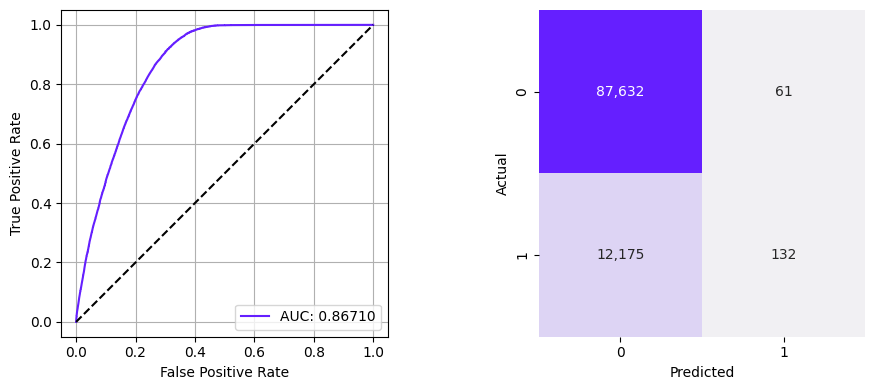

In [33]:
# Define plots size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)  # Ensure y_pred is probabilities for ROC
# Calculate AUC
roc_auc_dt = auc(fpr, tpr)
# Plot ROC curve
axes[0].plot(fpr, tpr, label=f'AUC: {roc_auc_dt:.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

# Convert probabilities to binary predictions
#threshold = 0.5  # Common threshold for binary classification
#y_pred_classes = (y_pred >= threshold).astype(int)  # Convert probabilities to class labels

#Or, predict using the model:
y_pred_bin = bayes_search.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt=',', ax=axes[1], cbar=False, cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True))
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [ ]:
# ROC AUC score: This score evaluates the model's ability to distinguish between classes.
    # A higher AUC_ROC score implies better discrimination between positive and negative classes across various thresholds.

# Kaggle Submission

In [46]:
print(test.shape) #7 MI rows!
test[:3]

(7669866, 15)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,previously_insured_annual_premium,previously_insured_vehicle_age,previously_insured_vehicle_damage,previously_insured_vintage
0,11504798,1,20,1,47,0,0,0,2630,160,228,3,1,1,244
1,11504799,0,47,1,28,0,1,1,37483,124,123,22988,0,0,266
2,11504800,0,47,1,43,0,1,1,2630,26,271,3,0,0,420


In [56]:
#drop response col (added on data cleaning)
test.drop(columns='response', inplace=True)

In [57]:
#predict on prod data:
y_hat_prod = bayes_search.predict_proba(test)[:,1]

In [58]:
#save id to build submission file
test_id = test['id'].copy()

In [60]:
#Predictions done:
print(y_hat_prod.shape)
y_hat_prod[:5]

(7669866,)


array([0.003202, 0.299115, 0.227925, 0.01966 , 0.067216])

In [63]:
# Prepare for submission: id + predictions:
# Create final dataset
df_sub = pd.concat([ pd.Series(test_id, name='id') , pd.Series(y_hat_prod, name='Target') ], axis=1)
df_sub[:3]

,id,Target
0,11504798,0.003
1,11504799,0.299
2,11504800,0.228


In [64]:
# Export to submit on Kaggle
df_sub.to_parquet('..\\data\\v9\\submission_v9.parquet', engine='pyarrow')